In [1]:
import _init_paths
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import caffe, os, sys, cv2
import argparse
from collections import Counter
import shutil

import xml.etree.ElementTree as ET
from lxml import etree

TEST_CLASSES = {
    'hands': 'hands',
    'faces': 'faces',
    'human': 'human',
    'wlcoco':'wlcoco',
    'wlDet':'wlDet'
}
MODEL_CLASSES = {
    'vgg_small':'VGG_CNN_M_1024',
    'vgg_large':'VGG16'
}
TEST_CLASS = TEST_CLASSES['wlDet']


cls_file = open('../' + TEST_CLASS + '_classes.txt', 'rb')
CLASSES = [cls.strip() for cls in cls_file.readlines()]
CLASSES = tuple(CLASSES)

cfg.TEST.HAS_RPN = True  # Use RPN for proposals

#MODELS_DIR = '/home/tomorning/py-faster-rcnn/models/'+ TEST_CLASS +'/VGG16/faster_rcnn_end2end/test.prototxt'
#NET = '/home/tomorning/py-faster-rcnn/output/faster_rcnn_end2end/' + \
#    TEST_CLASS + '/vgg16_faster_rcnn_iter_100000.caffemodel'
MODELS_DIR = '/home/tomorning/py-faster-rcnn/models/'+ TEST_CLASS +'/VGG_CNN_M_1024/faster_rcnn_end2end/test.prototxt'
NET = '/home/tomorning/py-faster-rcnn/output/faster_rcnn_end2end/' + \
    'wlDet' + '/wlDet_valdata_vgg_cnn_m_1024_faster_rcnn_iter_20000.caffemodel'
     #'wlDet' + '/wlDet_valdata_vgg16_faster_rcnn_iter_10000.caffemodel'
DETS_DIR = '/home/tomorning/py-faster-rcnn/output/detections/faces_vgg16'
    
prototxt = MODELS_DIR
caffemodel = NET
if not os.path.isfile(caffemodel):
    raise IOError(('{:s} not found.\nDid you run ./data/script/'
                       'fetch_faster_rcnn_models.sh?').format(caffemodel))

caffe.set_mode_gpu()
caffe.set_device(0)

net = caffe.Net(prototxt, caffemodel, caffe.TEST)

print '\n\nLoaded network {:s}'.format(caffemodel)

MIN_IOU = 0.5
CONF_THRESH = 0.8
NMS_THRESH = 0.15
min_box_size = 256



Loaded network /home/tomorning/py-faster-rcnn/output/faster_rcnn_end2end/wlDet/wlDet_valdata_vgg_cnn_m_1024_faster_rcnn_iter_20000.caffemodel


In [2]:
def vis_detections(im, class_names,dets,thresh = 0.8):
    """Draw detected bounding boxes."""
    if dets==None or len(dets) == 0:
        print 'Detect Nothing in THIS IMAGE!!!'
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    #for bbox_score in dets:
    for ind in range(len(dets)):
        bbox_score = dets[ind]
        class_name = class_names[ind]
        bbox = bbox_score[:4]
        score = bbox_score[-1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
        )
        ax.text(bbox[0], bbox[1] - 2,
                 '{:s} {:.3f}'.format(class_name, score),
                 bbox=dict(facecolor='blue', alpha=0.5),
                 fontsize=14, color='white')

    ax.set_title(('{} detections with '
                   'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                   thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [3]:
def bbox_overlaps(gt_boxes, query_boxes):
    """
     Calculate the overlaps between ground-truth boxes and query boxes.
     boxes are in the form of (xmin, ymin, xmax, ymax).
     :return list of corresponding overlaps
    """
    
    def calculate_overlap(gt_box, query_boxes):
        overlaps = []
        
        box_area = (gt_box[2] * gt_box[3])
        for query_box in query_boxes:
            iw = (
                min(gt_box[0] + gt_box[2], query_box[0] + query_box[2]) -
                max(gt_box[0], query_box[0])
            )
            if iw > 0:
                ih = (
                    min(gt_box[1] + gt_box[3], query_box[1] + query_box[3]) -
                    max(gt_box[1], query_box[1])
                )
                if ih > 0:
                    ua = float(
                        box_area +
                        query_box[2] * query_box[3] -
                        iw * ih
                    )
                    overlaps.append(iw * ih / ua)
                else:
                    overlaps.append(0)
            else:
                overlaps.append(0)
        return np.array(overlaps, dtype=np.float32)[np.newaxis,:]
    
    gt_boxes[:, 2] -= gt_boxes[:, 0]
    gt_boxes[:, 3] -= gt_boxes[:, 1]
    query_boxes[:,2] -= query_boxes[:, 0]
    query_boxes[:,3] -= query_boxes[:, 1]
    overlaps = np.zeros((0, len(query_boxes)), dtype=np.float32)
    for gt_box in gt_boxes:
        _overlaps = calculate_overlap(gt_box, query_boxes)
        overlaps = np.vstack((overlaps, _overlaps))
    
    return overlaps

In [4]:
def load_ground_truth(names, minSize = 25):
    ground_truths = []
    gt_names = []
    for name in names:
        xml = os.path.join('/home/tomorning/original_data/' +TEST_CLASS+ '/Annotations', name + '.xml')
        xml = open(xml, 'rb')
        tree = ET.parse(xml)
        root = tree.getroot()
        ground_truth_this = []
        gt_names_this = []
        for obj in root.iter('object'):
            obj_name = obj.find('name').text
            if not obj_name in CLASSES:
                continue
            gt_names_this.append(obj_name)
            xmlbox = obj.find('bndbox')
            b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), 
                 float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
            # convert to (x, y, w, h)
            xmin = int(b[0])
            ymin = int(b[2])
            xmax = int(b[1])
            ymax = int(b[3])
            this_gt_area = (ymax-ymin+1)* (xmax-xmin+1)
            #if this_gt_area <= min_box_size:
            if (ymax-ymin)<minSize or (xmax-xmin)<minSize:
                continue
            ground_truth_this.append([xmin, ymin, xmax, ymax, 1.0])
        ground_truths.append(np.array(ground_truth_this, dtype=np.int32))
        gt_names.append(gt_names_this)
    return ground_truths, gt_names

In [5]:
def load_test_images(Ftest):
    with open(Ftest, 'rb') as _f:
        names = [img.strip('\n') for img in _f.readlines()]
        gts, gt_names = load_ground_truth(names)
        imgs = [name+'.jpg' for name in names]
    return imgs, gts, gt_names
    #return imgs

In [6]:
def detect(net, image_name, thresh=0.5):
    if not os.path.exists(image_name):
        im_file = os.path.join('/home/tomorning/original_data/'+TEST_CLASS+'/JPEGImages', image_name)
    else:
        im_file = image_name
    im = cv2.imread(im_file)
    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()

    scores, boxes = im_detect(net, im)
    timer.toc()
    #print ('Detection took {:.3f}s for '
    #      '{:d} object proposals').format(timer.total_time, boxes.shape[0])
    
    dets_all = None
    class_names = []
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1  # because we skipped background
        cls_boxes = boxes[:, 4 * cls_ind:4 * (cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        inds = np.where(dets[:, -1] >= CONF_THRESH)[0]
        if len(inds) == 0:
            continue
        dets = dets[inds, :]

        if dets_all is None:
            dets_all = dets
            class_names = [cls] * len(dets)
        else:
            dets_all = np.vstack((dets_all, dets))
            class_names = class_names + [cls] * len(dets)
            
        #vis_detections(im, cls, dets_all, thresh=CONF_THRESH)
    #descend
    if not dets_all is None:     
        sorted_idx = np.argsort(dets_all,axis=0)[:,4][::-1]
        dets_all = dets_all[sorted_idx,:]
        class_names = [class_names[i] for i in sorted_idx]
    return im, class_names, dets_all

In [7]:
def insert_object_node(root_node,xmin,ymin,xmax,ymax,label):
    object_node = ET.SubElement(root_node,'object')
    name_node = ET.SubElement(object_node,'name')
    name_node.text = label
    pose_node = ET.SubElement(object_node,'pose')
    pose_node.text = 'Unspecified'
    truncated_node = ET.SubElement(object_node,'truncated')
    truncated_node.text = '0'
    difficult_node = ET.SubElement(object_node,'difficult')
    difficult_node.text = '0'

    bndbox_node = ET.SubElement(object_node,'bndbox')
    xmin_node = ET.SubElement(bndbox_node,'xmin')
    xmin_node.text = str(xmin)
    ymin_node = ET.SubElement(bndbox_node,'ymin')
    ymin_node.text = str(ymin)
    xmax_node = ET.SubElement(bndbox_node,'xmax')
    xmax_node.text = str(xmax)
    ymax_node = ET.SubElement(bndbox_node,'ymax')
    ymax_node.text = str(ymax)

In [8]:
def save_xml(im_name, overlaps, gts, dets):
    #create node
    root_node = ET.Element('annotation')

    folder_node = ET.SubElement(root_node,'folder')
    folder_node.text = im_name
    filename_node = ET.SubElement(root_node,'filename')
    filename_node.text = im_name
    path_node = ET.SubElement(root_node,'path')
    path_node.text =im_name
    

    source_node = ET.SubElement(root_node,'source')
    database_node = ET.SubElement(source_node,'database')
    database_node.text = TEST_CLASS
    
    size_node = ET.SubElement(root_node,'size')
    width_node = ET.SubElement(size_node,'width')
    width_node.text= str(0)
    height_node = ET.SubElement(size_node,'height')
    height_node.text = str(0)
    depth_node = ET.SubElement(size_node,'depth')
    depth_node.text = '3'

    segmented_node = ET.SubElement(root_node,'segmented')
    segmented_node.text = '0'
    
    if gts is not None:
        for i in range(gts.shape[0]):
            [xmin,ymin,xmax,ymax] = gts[i,:4]
            insert_object_node(root_node,xmin,ymin,xmax,ymax,'ground_truth')
    if dets is not None:
        for i in range(dets.shape[0]):
            [xmin,ymin,xmax,ymax] = dets[i,:4]
            insert_object_node(root_node,xmin,ymin,xmax,ymax,'detection')
    
    jpg = os.path.split(im_name)[-1]
    xml_name = os.path.splitext(jpg)[0]
    write_xml = DETS_DIR + '/' + xml_name + '.xml'
    
    tree = ET.ElementTree(root_node)
    tree.write(write_xml, encoding='utf-8', xml_declaration = True)
    
    #lxml
    parser = etree.XMLParser()
    document = etree.parse(write_xml, parser)
    document.write(write_xml,pretty_print = True, encoding = 'utf-8')

In [9]:
def single_test(ind):
    Ftest = '/home/tomorning/original_data/' + TEST_CLASS + '/ImageSets/Main/test.txt'
    test_imgs, gts, gt_names = load_test_images(Ftest)
    #test_imgs = load_test_images(Ftest)

    #detect(net, test_imgs[ind], thresh=CONF_THRESH)
    im, class_names, detection_boxes = detect(net, test_imgs[ind], thresh=CONF_THRESH)
    vis_detections(im,class_names, detection_boxes)
    vis_detections(im, gt_names[ind], gts[ind])

In [10]:
def batch_test(begin):
    Ftest = '/home/tomorning/original_data/' + TEST_CLASS + '/ImageSets/Main/test.txt'
    test_imgs, gts, gt_names = load_test_images(Ftest)
    test_imgs = test_imgs[begin:]
    gts = gts[begin:]
    
    _mean = 0.
    _av = 0.
    sum_mean = 0.
    sum_av = 0.
    gt_box_num =0.
    for ind in range(len(test_imgs)):
        if len(gts[ind])==0:
            print 'NO GT box', ind
            continue
        im,class_name, detection_boxes = detect(net, test_imgs[ind], thresh=CONF_THRESH)
        if detection_boxes is None:
            overlaps = np.zeros(len(gts[ind]))[:,np.newaxis]

        else:
            overlaps = bbox_overlaps(gts[ind].copy(), detection_boxes.copy())
        overlaps = np.max(overlaps, axis=1)
        pos_inds = np.where(overlaps > MIN_IOU)
        _mean_this = np.mean(overlaps)
        _av_this = float(len(overlaps[pos_inds])) / len(overlaps)
        print ind, ":", test_imgs[ind], ' mean:', _mean_this, ' av:', _av_this
        _mean += _mean_this
        sum_mean += np.sum(overlaps)
        sum_av += float(len(overlaps[pos_inds]))
        gt_box_num += len(gts[ind])
        _av += _av_this
        #print 'MEAN:', _mean / len(test_imgs), '\tAV:',_av / len(test_imgs)
        print 'MEAN:', sum_mean / gt_box_num, '\tAV:',sum_av / gt_box_num
        #save_xml(test_imgs[ind], overlaps, gts[ind], detection_boxes)

In [11]:
def wl_eval_recall_prec(begin,IoU_Thresh=MIN_IOU):
    Ftest = '/home/tomorning/original_data/' + TEST_CLASS + '/ImageSets/Main/test.txt'
    test_imgs, gts, gt_names = load_test_images(Ftest)
    test_imgs = test_imgs[begin:]
    gts = gts[begin:]
    
    _mean = 0.
    _av = 0.
    sum_mean = 0.
    sum_av = 0.
    
    tp = []
    fp = []
    gt_deted = []
    npos = 0
    all_det_score = np.zeros(0)
    for ind in range(len(test_imgs)):
        if len(gts[ind])==0:
            print 'NO GT box', ind
            continue
        npos += len(gts[ind])
        im,class_name, detection_boxes = detect(net, test_imgs[ind], thresh=CONF_THRESH)
        if detection_boxes is None:
            continue
        this_tp = np.array([0] * len(detection_boxes))
        this_fp = np.array([0] * len(detection_boxes))
        this_gt_deted = np.array([0] * len(gts[ind]))
        this_score = None
        
        if detection_boxes is None:
            overlaps = np.zeros(len(gts[ind]))[:,np.newaxis]
        else:
            overlaps = bbox_overlaps(gts[ind].copy(), detection_boxes.copy())
            this_score = detection_boxes[:,4]
        if not this_score is None:
            all_det_score = np.hstack([all_det_score, this_score])
            
        
        overlaps_of_obj = np.max(overlaps, axis=1)
        obj_pos_inds = np.where(overlaps_of_obj > IoU_Thresh)
        _mean_this = np.mean(overlaps_of_obj)
        _av_this = float(len(overlaps_of_obj[obj_pos_inds])) / len(overlaps_of_obj)
        sum_mean += np.sum(overlaps_of_obj)
        sum_av += float(len(overlaps_of_obj[obj_pos_inds]))
        
        argmax_overlaps = overlaps.argmax(axis=0)
        #overlaps = np.max(overlaps, axis=0) 
        max_overlaps = overlaps.max(axis=0)
        pos_inds = np.where(max_overlaps > IoU_Thresh )[0]
        this_fp[ np.where(~(max_overlaps> IoU_Thresh)) ]  = 1
        
        for det_idx in pos_inds:
            gt_ok_idx = argmax_overlaps[det_idx]
            if this_gt_deted[gt_ok_idx] == 0:
                this_tp[det_idx] = 1
                this_gt_deted[gt_ok_idx] = 1
            else:
                this_fp[det_idx] = 1
                
        if tp is None:
            tp = this_tp;fp= this_fp; gt_deted = this_gt_deted;
        else:
            tp = np.append(tp,this_tp)
            fp = np.append(fp,this_fp)
            gt_deted = np.append(gt_deted, this_gt_deted)
            
    argmax_idx_score = np.argsort(-all_det_score)

    tp = tp[argmax_idx_score]
    fp = fp[argmax_idx_score]
    
    tp_cumsum = np.cumsum(tp)
    fp_cumsum = np.cumsum(fp)
    rec = tp_cumsum/npos
    prec = tp_cumsum * 1./(tp_cumsum + fp_cumsum)
    ap = 0
    for t in range(11):
        tmp_p = prec[rec>=t*0.1]
        if len(tmp_p)==0:
            p = 0
        else:
            p = np.max(prec[rec>=t*0.1])
        ap=ap+p/11
    print 'IoU_Thresh:',IoU_Thresh
    print 'AP:',ap
    print 'IoU MEAN:', sum_mean / npos, '\tAverage Hit:',sum_av / npos
    plt.subplots(figsize=(12, 12))
    plt.plot(rec, prec, lw=2, color='navy',
         label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([np.min(prec)-0.2, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="lower left")
    plt.show()
    return ap



In [12]:
def wl_eval_recall(begin,IoU_Thresh=MIN_IOU):
    Ftest = '/home/tomorning/original_data/' + TEST_CLASS + '/ImageSets/Main/test.txt'
    test_imgs, gts, gt_names = load_test_images(Ftest)
    test_imgs = test_imgs[begin:]
    gts = gts[begin:]
    
    npos = 0
    gt_overlaps = np.zeros(0)
    thresholds =None
    for ind in range(len(test_imgs)):
        if len(gts[ind])==0:
            print 'NO GT box', ind
            continue
        npos += len(gts[ind])
        im,class_name, detection_boxes = detect(net, test_imgs[ind], thresh=CONF_THRESH)
        if detection_boxes is None:
            continue

        if detection_boxes is None:
            overlaps = np.zeros(len(gts[ind]))[np.newaxis,:]
        else:
            overlaps = bbox_overlaps(gts[ind].copy(), detection_boxes.copy())
            
        _gt_overlaps = np.zeros((gts[ind].shape[0]))
        
        for j in xrange(gts[ind].shape[0]):
            argmax_overlaps = overlaps.argmax(axis=1)
            max_overlaps = overlaps.max(axis=1)
            gt_ind = max_overlaps.argmax()
            gt_ovr = max_overlaps.max()
            if gt_ovr<0:
                continue
            box_ind = argmax_overlaps[gt_ind]
            _gt_overlaps[j] = overlaps[gt_ind,box_ind]
            assert(_gt_overlaps[j] == gt_ovr)
            overlaps[gt_ind,:] = -1
            overlaps[:,box_ind] = -1
        gt_overlaps = np.hstack((gt_overlaps, _gt_overlaps))
    
    gt_overlaps = np.sort(gt_overlaps)
    if thresholds is None:
        step = 0.05
        thresholds = np.arange(0.5, 0.95+ 1e-5, step)
    recalls = np.zeros_like(thresholds)
        
    for i, t in enumerate(thresholds):
        recalls[i] = (gt_overlaps >=t).sum() /float(npos)
    ar = recalls.mean()
    
    print 'Recall@0.5:{:.3f}'.format(recalls[0])
    print 'Recall@0.6:{:.3f}'.format(recalls[2])
    print 'Recall@0.7:{:.3f}'.format(recalls[4])
    print 'Recall@0.8:{:.3f}'.format(recalls[6])
    print 'Recall@0.9:{:.3f}'.format(recalls[8])
    print '{:.3f}'.format(ar)
    return {'recalls':recalls,'npos':npos}

In [13]:
recall_dict = wl_eval_recall(0)

Recall@0.5:0.737
Recall@0.6:0.689
Recall@0.7:0.567
Recall@0.8:0.343
Recall@0.9:0.074
0.448


In [14]:
print recall_dict['recalls'],recall_dict['npos']

[ 0.73717949  0.7275641   0.68910256  0.64423077  0.56730769  0.5
  0.34294872  0.18910256  0.07371795  0.00961538] 312


IoU_Thresh: 0.5
AP: 0.6945155956
IoU MEAN: 0.603316512914 	Average Hit: 0.740384615385


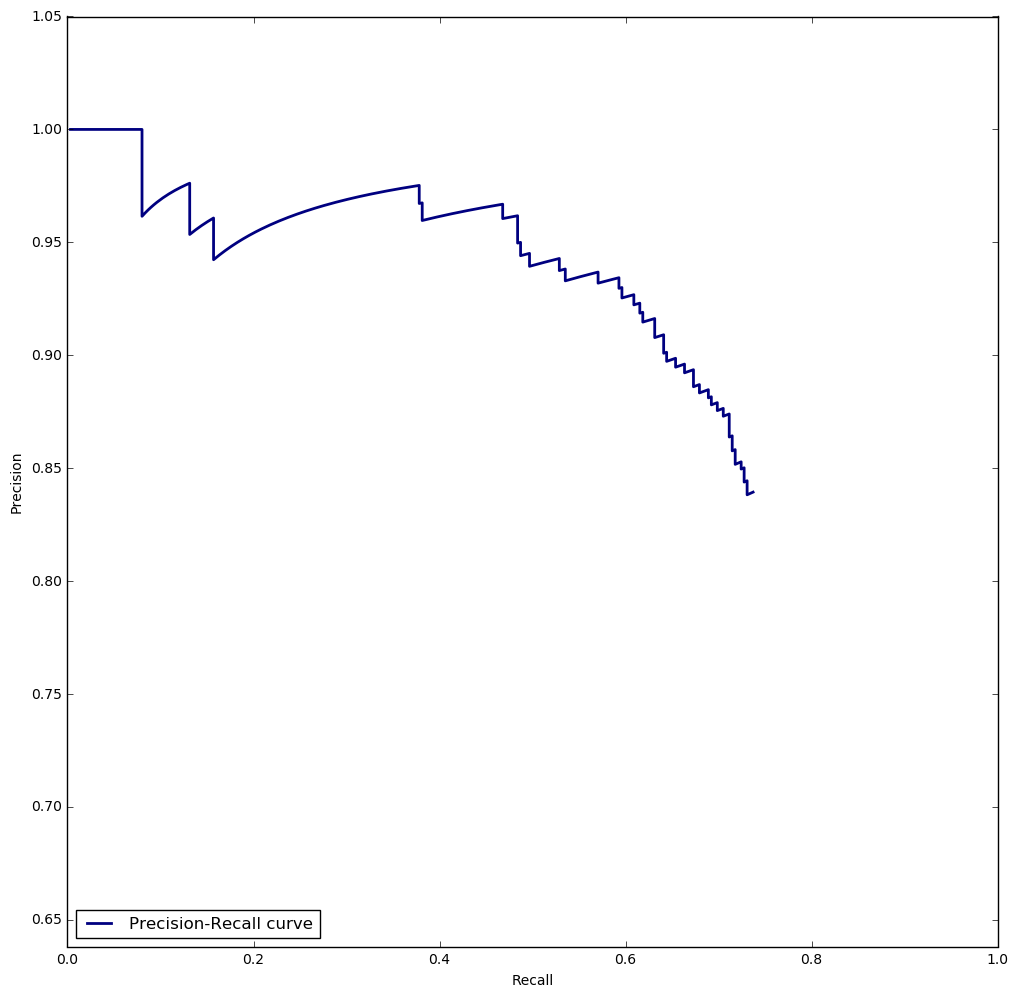

0.69451559560033849

In [15]:
wl_eval_recall_prec(0)

In [ ]:
batch_test(100)

In [ ]:
for ind in range(20):
    single_test(60+ind)

In [ ]:
img_dir = '/home/tomorning/tmp_img/'
for img_file in os.listdir(img_dir):
    img_name = img_dir + img_file
    #detect(net, test_imgs[ind], thresh=CONF_THRESH)
    im, class_names, detection_boxes = detect(net, img_name, thresh=CONF_THRESH)
    if detection_boxes==None:
        print 'Nothing detected',img_name
    vis_detections(im,class_names, detection_boxes)

In [ ]:
print CLASSES 